# Sina Weibo prediction

In [1]:
%pip install autograd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 674.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gc
import os
import torch
#import cuml
import umap
import warnings
from joblib import Memory
from jieba import analyse as jbanalyse
import numpy as np
import pandas as pd
import seaborn as sns
import functools as fn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import autograd.numpy as anp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import RegressorChain, ClassifierChain
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost.utils import get_gpu_device_count
from autograd import grad
from lightgbm import LGBMRegressor

RANDOM_STATE=8402
RNG=np.random.default_rng(seed=RANDOM_STATE)
CV_SPLITS=5
N_CV=1_000_000
BATCH_SIZE=(256+64)*2 # for 2 gpu approx 12GB mem-usage each
CACHE_DIR=Memory(location='joblib_cache', verbose=0)

warnings.filterwarnings("ignore", "use_inf_as_na")

def gpu_or_else(gpu, no_gpu):
    return gpu if torch.cuda.is_available() else no_gpu
print(gpu_or_else('GPU available', 'No GPU available using CPU'))

2024-05-24 07:41:17.612310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 07:41:17.612436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 07:41:17.892004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU available


Defining the loss function

In [3]:
def mixed_loss(y_true: ArrayLike, y_pred: ArrayLike, bias=[5,3,3], scaling=[.5,.25,.25], thresold=.8):
    precision = 1 - anp.sum((anp.abs(y_pred-y_true)/(y_true + bias)) * scaling, axis=1)
    sgn_precision = precision > thresold
    count_row_sum = anp.sum(anp.clip(y_true, a_min=None, a_max=100), axis=1) + 1
    return anp.sum(count_row_sum * sgn_precision) / anp.sum(count_row_sum)

def mixed_loss_objective(y_true, y_pred, weights, loss_f=mixed_loss):
    y_pred = anp.array(y_pred)
    y_true = anp.array(y_true)
    grad_loss = grad(loss_f, 1)
    gradients = grad_loss(y_true, y_pred)
    hessians = -anp.ones_like(gradients)

    if weights is not None:
        weights = anp.array(weights)
        gradients *= weights
        hessians *= weights

    return gradients, hessians
        

mixed_scorer = make_scorer(mixed_loss, greater_is_better=True)

## Dataset preperation

In [4]:
def file_to_df(filename, col_names=['uid', 'mid', 'ts', 'forward_n', 'comment_n', 'like_n', 'content']):
    """Helper to parse data. Contains hardcoded logic"""
    df = pd.read_csv(filename, sep='\t', names=col_names)
    if 'ts' in col_names:
        df['ts'] = pd.to_datetime(df['ts'])
    return df

In [5]:
Xy_tv = file_to_df('/kaggle/input/sna-weibo-data/Weibo Data/weibo_train_data(new)/weibo_train_data.txt')
Xy_test = file_to_df(
    '/kaggle/input/sna-weibo-data/Weibo Data/weibo_predict_data(new)/weibo_predict_data.txt',
    col_names=['uid', 'mid', 'ts', 'content']
)

In [6]:
Xy_tv.isna().sum(), Xy_test.isna().sum()

(uid          0
 mid          0
 ts           0
 forward_n    0
 comment_n    0
 like_n       0
 content      3
 dtype: int64,
 uid        0
 mid        0
 ts         0
 content    1
 dtype: int64)

In [7]:
X_tv = Xy_tv.dropna().drop(['forward_n', 'comment_n', 'like_n'], axis=1)
y_tv = Xy_tv.dropna()[['forward_n', 'comment_n', 'like_n']].replace([np.inf, -np.inf], np.nan)
X_test = Xy_test.dropna()

In [8]:
Xy_tv.shape, X_tv.shape, y_tv.shape

((1225088, 7), (1225085, 4), (1225085, 3))

In [9]:
X_tv.head()

,uid,mid,ts,content
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,看点不能说的，你们都懂[笑cry]
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,111多张


In [10]:
y_tv.head()

,forward_n,comment_n,like_n
0,0,0,0
1,0,0,0
2,0,0,0
3,0,4,3
4,0,0,0


In [11]:
Xy_test.shape, X_test.shape

((177923, 4), (177922, 4))

In [12]:
Xy_test.head()

,uid,mid,ts,content
0,c01014739c046cd31d6f1b4fb71b440f,0cd5ef13eb11ed0070f7625b14136ec9,2015-08-19 22:44:55,Xah Emacs Tutorial http://t.cn/zWoY9IZ
1,fa5aed172c062c61e196eac61038a03b,7cce78a4ad39a91ec1f595bcc7fb5eba,2015-08-01 14:06:31,卖水果老人因没住处夜宿酒店门口 被车碾死 http://t.cn/RL0Hw8J （分享自@...
2,77fc723c196a45203e70f4d359c96946,a3494d8cf475a92739a2ffd421640ddf,2015-08-04 10:51:38,不要学习没有用的理论？ 不是：要学习，但要知道这个理论，为什么没有用？真实有用的理论是什么。...
3,e4097b07f34366399b623b94f174f60c,6b89aea5aa7af093dde0894156c49dd3,2015-08-16 14:59:19,[幸运之星] -恭喜！您的新浪微博账号已被系统确认为“新浪五周年”活动二等奖幸运用户。请登陆...
4,d43f7557c303b84070b13aa4eeeb21d3,0bdeff19392e15737775abab46dc5437,2015-08-04 22:30:46,【Lennart Poettering宣布首届Systemd会议】受争议Linux初始化系统...


## Data analysis

### Navive analysis

In [13]:
def embedd(
    data,
    vectorizer=TfidfVectorizer(stop_words='english', max_features=512),
    reducer=gpu_or_else(
        umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),# TODO maybe enable GPU: cuml.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),
        umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2),
    )
):
    embeddings = vectorizer.fit_transform(data)
    return reducer.fit_transform(embeddings)

def plot_embeddings(embeddings, y):
    categories = np.sum(y * [.5, .25, .25], axis=1)
    alhpa_vals = np.log10(categories / categories.max() + 0.01) / np.log10(1.01)
    scaled_alpha_vals = np.clip((alhpa_vals - alhpa_vals.min()) / (alhpa_vals.max() - alhpa_vals.min()), a_min=None, a_max=1)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=categories,
        cmap='Spectral',
        s=5,
        alpha=scaled_alpha_vals
    )
    plt.colorbar(scatter)
    plt.title('Projection of Text Embeddings', fontsize=18)
    plt.xlabel('dim 1', fontsize=14)
    plt.ylabel('dim 2', fontsize=14)
    plt.grid(True)
    plt.show()

### Naive Embeddings

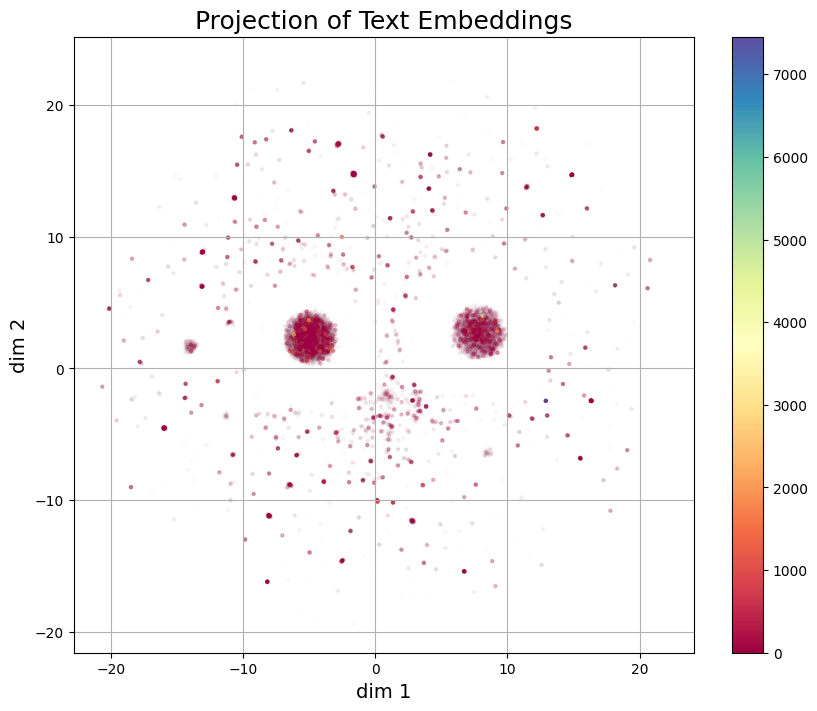

In [14]:
plot_embeddings(
    embedd(X_tv.content.sample(100_000, random_state=RANDOM_STATE)),
    y_tv.sample(100_000, random_state=RANDOM_STATE)
)

### Jieba embeddings

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.136 seconds.
Prefix dict has been built successfully.
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


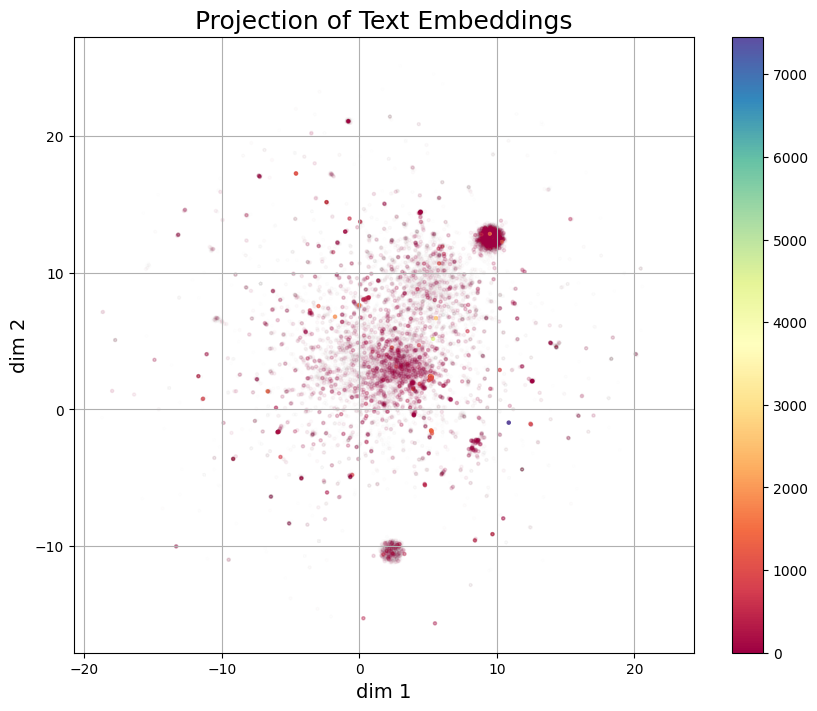

In [15]:
plot_embeddings(
    embedd(
        X_tv.content.sample(100_000, random_state=RANDOM_STATE),
        vectorizer=TfidfVectorizer(analyzer=fn.partial(jbanalyse.extract_tags), max_features=512),
    ),
    y_tv.sample(100_000, random_state=RANDOM_STATE),
)

### Huggingface embeddings

In [16]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

class ChineseBertVectorizer():
    def __init__(
        self,
        device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
        batch_size=1024,
        verbose=0
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(
            "google-bert/bert-base-chinese", 
            padding=True,
            truncation=True
        )
        self.model = AutoModel.from_pretrained("google-bert/bert-base-chinese")
        self.device = device
        self.batch_size=batch_size
        self.verbose=verbose
    
    def fit_transform(self, data, batch_size=None, verbose=None):
        if not isinstance(data, list):
            data = data.tolist()
        if not batch_size:
            batch_size = self.batch_size
        if not verbose:
            verbose = self.verbose
        
        try:
            return self.get_embeddings(data, batch_size=batch_size, verbose=verbose)
        finally:
            if verbose:
                print('cleaning up...')
            if verbose > 1:
                print(torch.cuda.memory_summary())
            gc.collect()
            torch.cuda.empty_cache()
            if verbose:
                print('done cleaning')
            if verbose > 1:
                print(torch.cuda.memory_summary())


    def get_embeddings(self, data, batch_size, verbose=0):
        if verbose:
            print('tokenizing...')
        encoded_input = self.tokenizer(
            data, padding=True, truncation=True, return_tensors='pt'
        )
        dataset = TextDataset(encoded_input)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        embeddings = []
        embedder = nn.DataParallel(self.model)
        embedder = embedder.to(self.device)
        for batch in tqdm(loader, disable=verbose<1, desc='embedding', unit='batch'):
            batch_ = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                if verbose>1:
                    print(torch.cuda.memory_summary())
                    
                outputs = embedder(**batch_)
                if self.device.type == 'cuda':
                    batch_embeddings = outputs.last_hidden_state[:, 0, :]
                    embeddings.append(batch_embeddings.cpu())
                    for v in batch_.values():
                             del v
                    del batch_
                    del outputs
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    batch_embeddings = outputs.last_hidden_state[:, 0, :]
                    embeddings.append(batch_embeddings.cpu())
        
        if self.device.type == 'cuda':
            del embedder
            gc.collect()
            torch.cuda.empty_cache()

        embeddings = torch.cat(embeddings, dim=0)
        if verbose:
            print('embeddings done')

        return embeddings

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizing...


embedding:   0%|          | 0/157 [00:00<?, ?batch/s]

embeddings done
cleaning up...
done cleaning


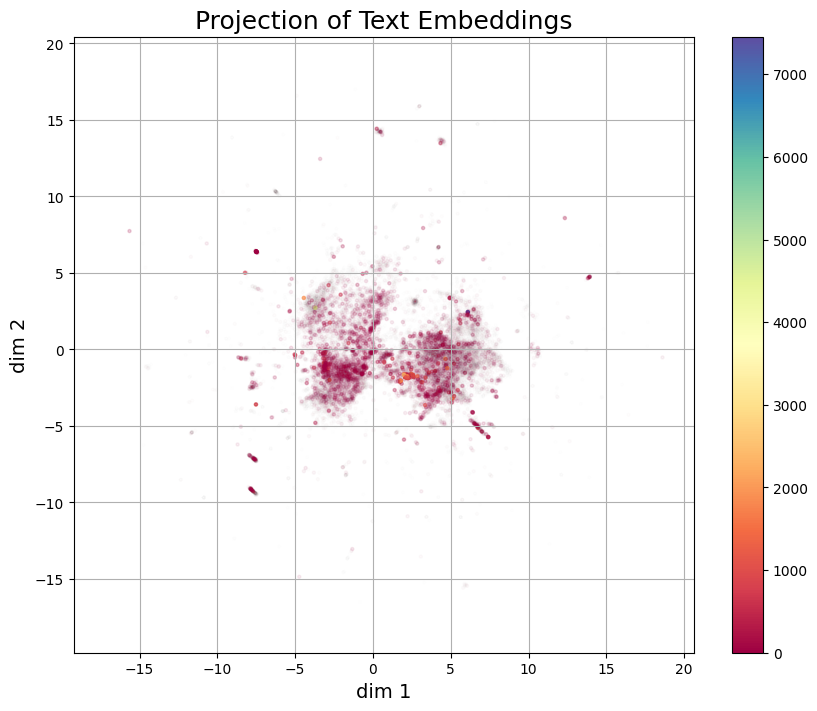

In [17]:
plot_embeddings(
    embedd(
        X_tv.content.sample(100_000, random_state=RANDOM_STATE),
        vectorizer=ChineseBertVectorizer(batch_size=BATCH_SIZE, verbose=1)
    ),
    y_tv.sample(100_000, random_state=RANDOM_STATE)
)

### Target analysis

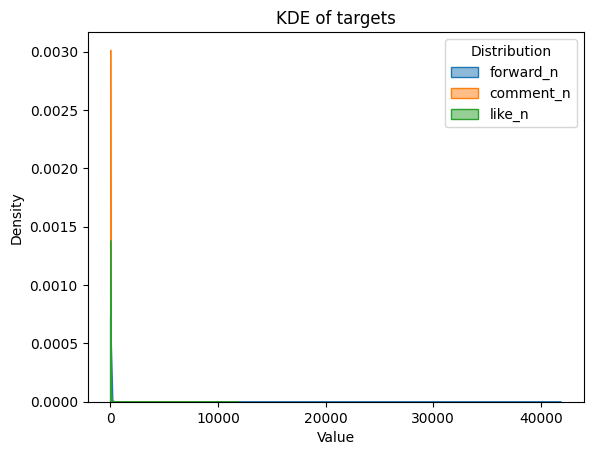

In [18]:
for column in y_tv.columns:
    sns.kdeplot(y_tv[column], label=column, fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of targets')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Distribution')

Let's log scale it to make it more gaussian

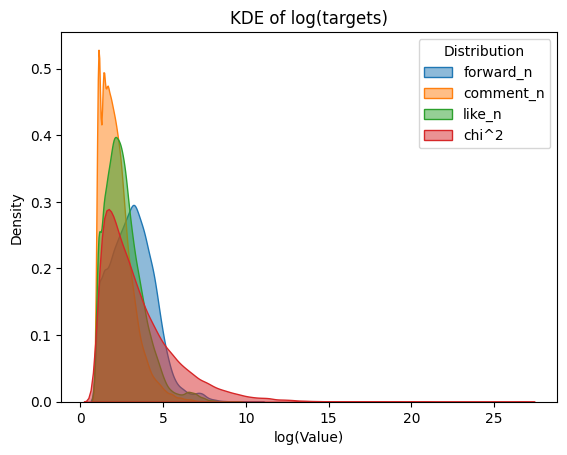

In [19]:
y_tv_no_low = y_tv[np.all(y_tv > 2, axis=1)]
for column in y_tv.columns:
    sns.kdeplot(np.log(y_tv_no_low[column]), label=column, fill=True, common_norm=False, alpha=0.5)
    
sns.kdeplot(RNG.chisquare(2.5,size=y_tv_no_low.shape[0])+1, label='chi^2', fill=True, common_norm=False, alpha=0.5)

plt.title('KDE of log(targets)')
plt.xlabel('log(Value)')
plt.ylabel('Density')
plt.legend(title='Distribution')

### User segementation

In [20]:
TOP_K_UID=10

In [21]:
user_segementation_df = X_tv[['uid']]
user_segementation_df.loc[: ,['forward_n', 'comment_n', 'like_n']] = y_tv
user_segementation_df.loc[: ,['popularity']] = (y_tv * [.5, .25, .25]).sum(axis=1)

In [22]:
np.unique(user_segementation_df[user_segementation_df.popularity > 10].uid).shape

(2449,)

In [23]:
user_segementation_df.loc[:, ['median_popularity']] = user_segementation_df['uid'].map(user_segementation_df.groupby('uid')['popularity'].median())
user_segementation_df.loc[:, ['mean_popularity']] = user_segementation_df['uid'].map(user_segementation_df.groupby('uid')['popularity'].mean())

In [24]:
user_segementation_df.head()

,uid,forward_n,comment_n,like_n,popularity,median_popularity,mean_popularity
0,d38e9bed5d98110dc2489d0d1cac3c2a,0,0,0,0.00,0.0,0.627724
1,fa13974743d3fe6ff40d21b872325e9e,0,0,0,0.00,0.0,0.233083
2,da534fe87e7a52777bee5c30573ed5fd,0,0,0,0.00,0.0,0.107143
3,e06a22b7e065e559a1f0bf7841a85c51,0,4,3,1.75,1.5,3.276644
4,f9828598f9664d4e347ef2048ce17734,0,0,0,0.00,0.0,0.132075


In [25]:
top_uids = user_segementation_df.groupby('uid')['popularity'].sum().sort_values(ascending=False)[:TOP_K_UID].index
top_k_uid_df = user_segementation_df[user_segementation_df['uid'].isin(top_uids)]
top_k_uid_df.shape

(10565, 7)

In [26]:
top_k_uid_df.sort_values('popularity', ascending=False).head()

,uid,forward_n,comment_n,like_n,popularity,median_popularity,mean_popularity
960724,42fffa7b95d37f3d414114974772d14f,41850,1767,11697,24291.00,38.5,158.580508
21949,e88330514585dc40b7cb8f48c0e0ea2a,19255,7231,1557,11824.50,661.0,769.311528
1033865,8507f224ff141fcdc92d6cca325a948a,20954,4266,33,11551.75,7.0,134.566787
1135986,e88330514585dc40b7cb8f48c0e0ea2a,18609,837,6304,11089.75,661.0,769.311528
594288,e88330514585dc40b7cb8f48c0e0ea2a,14796,5075,1007,8918.50,661.0,769.311528


In [27]:
no0_top_k_uid_df = top_k_uid_df.astype({k: float for k in ['forward_n','comment_n','like_n','popularity','median_popularity', 'mean_popularity']})
no0_top_k_uid_df.loc[:,['forward_n','comment_n','like_n','popularity','median_popularity', 'mean_popularity']] = no0_top_k_uid_df[['forward_n','comment_n','like_n','popularity','median_popularity', 'mean_popularity']] +.0001

/tmp/ipykernel_24/939236513.py:15: RuntimeWarning: overflow encountered in exp
  return f"{np.exp(x):.2f}"


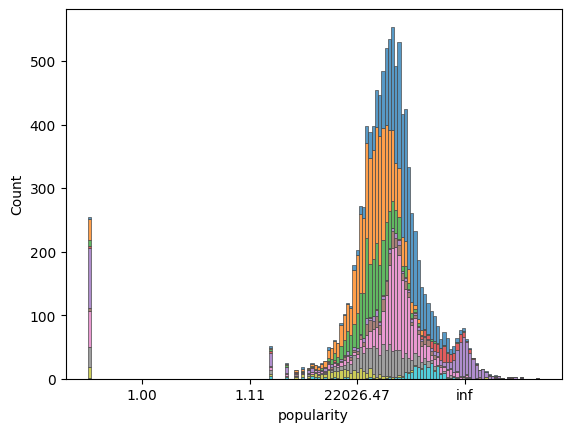

In [28]:
warnings.filterwarnings('ignore', category=FutureWarning)
ax = sns.histplot(
    no0_top_k_uid_df,
    x='popularity', hue='uid',
    multiple='stack',
    #palette='light:m_r',
    edgecolor='.3',
    linewidth=.5,
    log_scale=True,
    legend=False,
)

def exp_formatter(x, pos):
    """Converts log scale labels back to the exponential scale"""
    return f"{np.exp(x):.2f}"

ax.get_xaxis().set_major_formatter(mtick.FuncFormatter(exp_formatter))
warnings.simplefilter('default', category=FutureWarning)

In [29]:
%%script echo 'skip for now'
pal = sns.color_palette(palette='coolwarm', n_colors=TOP_K_UID)

g = sns.FacetGrid(top_k_uid_df, row='uid', hue='median_popularity', aspect=15, height=.75, palette=pal)

g.map(sns.boxplot, y='popularity', clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.boxplot, y='popularity', clip_on=False, 
      color="w", lw=2)

#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

#for i, ax in enumerate(g.axes.flat):
#    ax.text(0, 0, top_uids[i],
#            fontweight='bold', fontsize=7,
#            color=ax.lines[-1].get_color(),
#            ha='left', va='center')

g.fig.subplots_adjust(hspace=1)#-.3)

g.set_titles('')
g.set(yticks=[], ylabel='')
g.despine(bottom=True, left=True)

ax = g.axes.flat[-1]
plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Popularity (forwards, comments and likes combined)', fontweight='bold', fontsize=15)
_ = g.fig.suptitle(f'Post potpularity of top {TOP_K_UID} users',
               ha='right',
               fontsize=20,
               fontweight=20)

skip for now


## Model definition

### Transformer definitions

In [30]:
def extract_tags_cn(text):
    return jbanalyse.extract_tags(text)

@CACHE_DIR.cache
def cached_tfidf_fit(tf_idf_params, X):
    return TfidfVectorizer(**tf_idf_params).fit(X)

class TfIdfCachedTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        tf_idf_params={'analyzer': extract_tags_cn, 'max_features': 512},
        cached_fitted_tf_idf=cached_tfidf_fit,
    ):
        self.tf_idf_params=tf_idf_params
        self.cached_fitted_tf_idf=cached_fitted_tf_idf

    def fit(self, X, y=None):
        self.tf_idf = self.cached_fitted_tf_idf(self.tf_idf_params, X.iloc[:, 0])
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X_trans = pd.DataFrame.sparse.from_spmatrix(
            self.tf_idf.transform(X.iloc[:, 0]),
            columns=self.tf_idf.get_feature_names_out()
        )
        return X_trans
    
    def get_feature_names_out(self, names=None):
        return self.tf_idf.get_feature_names_out(names)


class DateTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_col='ts', expand=['hour', 'minute'], drop=True):
        self.datetime_col = datetime_col
        self.expand = expand
        self.drop = drop

    def fit(self, X, y=None):
        self.datetime_col_loc = X.columns.get_loc(self.datetime_col)
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X_transformed = pd.DataFrame(X)
        X_transformed[self.datetime_col] = pd.to_datetime(X.iloc[:, self.datetime_col_loc])
        if 'hour' in self.expand:
            X_transformed['hour'] = X.iloc[:, self.datetime_col_loc].dt.hour
        if 'minute' in self.expand:
            X_transformed['minute'] = X.iloc[:, self.datetime_col_loc].dt.minute
        if 'second' in self.expand:
            X_transformed['second'] = X.iloc[:, self.datetime_col_loc].dt.second
        if self.drop:
            X_transformed = X_transformed.drop(X_transformed. columns[self.datetime_col_loc], axis=1)
        return X_transformed


class PopularityTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        classifier=ClassifierChain(
                CatBoostClassifier(
                    iterations=2000,
                    task_type=gpu_or_else('GPU', 'CPU'),
                    devices=list(range(get_gpu_device_count())),
                    boosting_type='Plain',
                    verbose=False,
                )
        ),
        get_classes=lambda y: next(
            (l for t, l in [
                (1, 0),
                (6, 5),
                (101, 100),
                (1_001, 1_000),
                (10_001, 10_000)
            ] if y <= t),
            10_001
        )
    ):
        self.classifier = classifier
        self.get_classes = np.vectorize(get_classes)

    def fit(self, X, y=None):
        y_ = self.get_classes(y)
        self.classifier = self.classifier.fit(X, y_)
        return self

    def transform(self, X: pd.DataFrame, y=None):
        X[[str(i) for i in self.classifier.classes_]] = self.classifier.predict_proba(X)
        return X
    
class OutputRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        model,
        transformation=lambda x: np.where(np.round(x)<=1, 0, np.round(x))
    ):
        self.model = model
        self.transformation = transformation

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        predictions = self.model.predict(X)
        return self.transformation(predictions)

In [31]:
%%script echo 'TODO fix'
p = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), make_column_selector(pattern='uid'))
    ),
    PopularityTransformer()#TODO: fix probability prediction
).fit(X_tmp, y_tmp)

TODO fix


In [32]:
%%script echo 'TODO fix'
p.steps[1][1].classifier.predict(X_tmp)

TODO fix


### Userid Model

In [33]:
def get_user_id_model(outputkwargs={}, gbkwargs={}):
    return make_pipeline(
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'), make_column_selector(pattern='uid'))
        ),
        RegressorChain(
            OutputRegressor(
                LGBMRegressor(
                    device=gpu_or_else('cpu', 'cpu'),#'cuda' need special build
                    verbose=0,
                    **gbkwargs,
                ),
                **outputkwargs,
            ),
            verbose=False
        )
    )

### Catboost all features

In [34]:
def get_cat_all_features_model(outputkwargs={}, gbkwargs={}): 
    return make_pipeline(
        DateTimeTransformer(datetime_col='ts', expand=['hour', 'minute', 'second'], drop=True),
        make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'),['uid', 'mid']),
            ('passthrough',['hour', 'minute', 'second']),
            (TfIdfCachedTransformer(),['content']),
        ),
        RegressorChain(
            OutputRegressor(
                LGBMRegressor(
                    device=gpu_or_else('cpu', 'cpu'),
                    verbose=0,
                    **gbkwargs,
                ),
                **outputkwargs
            ),
            verbose=False
        )
    )

### Model list

In [35]:
# TODO: cat boost sklearn.MutiRegression with maxbe custom loss to optimize

models: list[tuple[str,BaseEstimator]] = [
    ('base-0', DummyRegressor(strategy='constant', constant=[0,0,0])),
    ('user-id', get_user_id_model()),
    (
        'user-id<2',
        get_user_id_model(
            outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
        )
    ),
    (
        'user-id-2000',
        get_user_id_model(
            gbkwargs={'num_iterations': 2_000},
            outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
        )
    ),
    #(
    #    'user-id-6000',
    #    get_user_id_model(
    #        gbkwargs={'num_iterations': 6_000},
    #        outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
    #    )
    #),
    ('gb-all', get_cat_all_features_model()),
    (
        'gb-all<2', 
         get_cat_all_features_model(
            outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
         )
    ),
    (
        'gb-all-3000',
        get_cat_all_features_model(
            gbkwargs={'num_iterations': 3_000},
            outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
        )
    ),
    (
        'gb-all-6000',
        get_cat_all_features_model(
            gbkwargs={'num_iterations': 6_000},
            outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
        )
    ),
]

## Eval

In [36]:
ts_cv = TimeSeriesSplit(n_splits=CV_SPLITS)

In [37]:
#TODO with joblib.parallel_backend('loky'): 
scores = {
    n: cross_val_score(
        m,
        X_tv[:N_CV],
        y_tv[:N_CV],
        cv=ts_cv,
        scoring=mixed_scorer,
        #error_score='raise'
    ) for n, m in tqdm(models, desc='eval models', unit='cv')
}

eval models:   0%|          | 0/8 [00:00<?, ?cv/s]

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_w

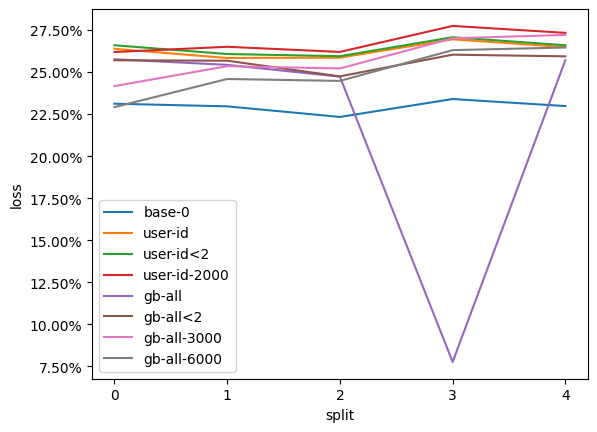

In [38]:
ax = pd.DataFrame(scores).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=2))
ax.set_xticks(np.arange(CV_SPLITS))
ax.set_ylabel('loss')
_ = ax.set_xlabel('split')

## Train and predict test

In [39]:
test_model = get_cat_all_features_model(
    gbkwargs={'num_iterations': 3_000},
    outputkwargs={'transformation': lambda x: np.where(np.round(x)<=2, 0, np.round(x))},
)

In [40]:
test_model = test_model.fit(X_tv, y_tv)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [41]:
y_pred = test_model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


In [42]:
pred_out = X_test[['uid', 'mid']]

In [43]:
pred_out.loc[:, 'predictions'] = [ f'{f},{c},{l}' for f,c,l in y_pred.astype(int)]

/tmp/ipykernel_24/2687242901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_out.loc[:, 'predictions'] = [ f'{f},{c},{l}' for f,c,l in y_pred.astype(int)]


In [44]:
pred_out.to_csv('peredictions.txt', sep=' ', quoting=False, index=False, header=False)